In [1]:
import torch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
from torch import nn, optim 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import cycle
from collections import Counter
%matplotlib inline
import random
from torch.utils import data
import os
from tqdm import tqdm


In [2]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
torch.backends.cudnn.deterministic = True

In [3]:
data_x=pd.read_csv("data_x_new.csv")
data_t=pd.read_csv("data_t_new.csv")
data_xx=pd.read_csv("data_x_x.csv")

In [4]:
h10_x=data_x.iloc[:, [0]]#初值x,t
h10_t=data_x.iloc[:, [1]]
h10_R=data_x.iloc[:,[2]]#初值h实部
h10_C=data_x.iloc[:,[3]]#初值h虚部
hb_x1=data_t.iloc[:,[1]]#边值-5，t
hb_t1=data_t.iloc[:,[0]]
hb_x2=data_t.iloc[:,[2]]#边值5，t
hb_t2=data_t.iloc[:,[0]]

h20_x=data_x.iloc[:, [0]]#初值x,t
h20_t=data_x.iloc[:, [1]]
h20_R=data_x.iloc[:,[4]]#初值h实部
h20_C=data_x.iloc[:,[5]]#初值h虚部

h30_x=data_xx.iloc[:, [0]]
h30_t=data_xx.iloc[:, [1]]
h30_r1=data_xx.iloc[:, [2]]
h30_c1=data_xx.iloc[:, [3]]
h30_r2=data_xx.iloc[:, [4]]
h30_c2=data_xx.iloc[:, [5]]

In [5]:
x = data_x['x']
t = data_t['t']

In [6]:
X, T = np.meshgrid(x,t)

In [7]:
hf= np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

In [8]:
hf_x=hf[:,[0]]
hf_t=hf[:,[1]]

In [9]:
train10_x,test10_x,train10_t,test10_t,train10_r,test10_r,train10_c,test10_c,trainb_x1,testb_x1,trainb_t1,testb_t1,trainb_x2,testb_x2,trainb_t2,testb_t2,train20_r,test20_r,train20_c,test20_c = train_test_split(h10_x,h10_t,h10_R,h10_C,hb_x1,hb_t1,hb_x2,hb_t2,h20_R,h20_C,test_size=0.2)

train30_x,test30_x,train30_t,test30_t,train30_r1,test30_r1,train30_c1,test30_c1,train30_r2,test30_r2,train30_c2,test30_c2=train_test_split(h30_x,h30_t,h30_r1,h30_c1,h30_r2,h30_c2)


In [10]:
trainu_x, testu_x, trainu_t, testu_t = train_test_split(hf_x, hf_t, test_size=0.2)



In [11]:
train10_x=torch.from_numpy(train10_x.to_numpy()).float()
train10_t=torch.from_numpy(train10_t.to_numpy()).float()

train10_r=torch.from_numpy(train10_r.to_numpy()).float()
train10_c=torch.from_numpy(train10_c.to_numpy()).float()

trainb_x1=torch.from_numpy(trainb_x1.to_numpy()).float()
trainb_t1=torch.from_numpy(trainb_t1.to_numpy()).float()
trainb_x2=torch.from_numpy(trainb_x2.to_numpy()).float()
trainb_t2=torch.from_numpy(trainb_t2.to_numpy()).float()

# train20_x=torch.from_numpy(train20_x.to_numpy()).float()
# train20_t=torch.from_numpy(train20_t.to_numpy()).float()
train20_r=torch.from_numpy(train20_r.to_numpy()).float()
train20_c=torch.from_numpy(train20_c.to_numpy()).float()


train30_x=torch.from_numpy(train30_x.to_numpy()).float()
train30_t=torch.from_numpy(train30_t.to_numpy()).float()
train30_r1=torch.from_numpy(train30_r1.to_numpy()).float()
train30_c1=torch.from_numpy(train30_c1.to_numpy()).float()
train30_r2=torch.from_numpy(train30_r2.to_numpy()).float()
train30_c2=torch.from_numpy(train30_c2.to_numpy()).float()

trainu_x=torch.from_numpy(trainu_x).float()
trainu_t=torch.from_numpy(trainu_t).float()

In [12]:
test10_x=torch.from_numpy(test10_x.to_numpy()).float()
test10_t=torch.from_numpy(test10_t.to_numpy()).float()
test10_r=torch.from_numpy(test10_r.to_numpy()).float()
test10_c=torch.from_numpy(test10_c.to_numpy()).float()

testb_x1=torch.from_numpy(testb_x1.to_numpy()).float()
testb_t1=torch.from_numpy(testb_t1.to_numpy()).float()
testb_x2=torch.from_numpy(testb_x2.to_numpy()).float()
testb_t2=torch.from_numpy(testb_t2.to_numpy()).float()

# test20_x=torch.from_numpy(test20_x.to_numpy()).float()
# test20_t=torch.from_numpy(test20_t.to_numpy()).float()
test20_r=torch.from_numpy(test20_r.to_numpy()).float()
test20_c=torch.from_numpy(test20_c.to_numpy()).float()

testu_x=torch.from_numpy(testu_x).float()
testu_t=torch.from_numpy(testu_t).float()

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [14]:
class DNN(torch.nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 4)
        )

    def forward(self, x):
        return self.net(x)

In [15]:
class PhysicsInformedNN():
    def __init__(self, u10_x, u10_t, u10_r, u10_c, ub_x1, ub_t1, ub_x2, ub_t2, u20_r, u20_c, uf_x, uf_t,u30_x,u30_t,u30_r1,u30_c1,u30_r2,u30_c2):
        self.u10_x = torch.tensor(u10_x, requires_grad=True).float().to(device)
        self.u10_t = torch.tensor(u10_t, requires_grad=True).float().to(device)
        self.u10_r = torch.tensor(u10_r, requires_grad=True).float().to(device)
        self.u10_c = torch.tensor(u10_c, requires_grad=True).float().to(device)
        
        self.ub_x1 = torch.tensor(ub_x1, requires_grad=True).float().to(device)
        self.ub_x2 = torch.tensor(ub_x2, requires_grad=True).float().to(device)
        self.ub_t1 = torch.tensor(ub_t1, requires_grad=True).float().to(device)
        self.ub_t2 = torch.tensor(ub_t2, requires_grad=True).float().to(device)
        
#         self.u20_x = u20_x.clone().detach().requires_grad_(True).float().to(device)
#         self.u20_t = torch.tensor(u20_t, requires_grad=True).float().to(device)
        self.u20_r = torch.tensor(u20_r, requires_grad=True).float().to(device)
        self.u20_c = torch.tensor(u20_c, requires_grad=True).float().to(device)
        
        self.u30_x = torch.tensor(u30_x, requires_grad=True).float().to(device)
        self.u30_t = torch.tensor(u30_t, requires_grad=True).float().to(device)
        self.u30_r1 = torch.tensor(u30_r1, requires_grad=True).float().to(device)
        self.u30_c1 = torch.tensor(u30_c1, requires_grad=True).float().to(device)
        self.u30_r2 = torch.tensor(u30_r2, requires_grad=True).float().to(device)
        self.u30_c2 = torch.tensor(u30_c2, requires_grad=True).float().to(device)
      
        
        self.uf_x = torch.tensor(uf_x,requires_grad=True).float().to(device)
        self.uf_t = torch.tensor(uf_t,requires_grad=True).float().to(device)
        
        self.lambda_1 = torch.tensor([0.8], requires_grad=True).to(device)
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        
        self.lambda_2 = torch.tensor([2.2], requires_grad=True).to(device)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        self.dnn = DNN().to(device)
        self.optimizer = torch.optim.Adam([
            {'params':self.dnn.parameters()},
            {'params': [self.lambda_1], 'lr': 0.00021},
            {'params': [self.lambda_2], 'lr': 0.0001}
        ],lr=0.012 )
        
        self.iter = 0
    
        self.losshistory=[]
    def net_u(self, x, t):  
        u1 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,0],1)
        v1 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,1],1)
        u2 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,2],1)
        v2 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,3],1)
        return u1, v1, u2, v2

    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        beta=1
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        lambda_3 = -1
        lambda_4 = 0
        u1, v1,u2, v2= self.net_u(x, t)
        
        u1_t = torch.autograd.grad(
            u1, t, 
            grad_outputs=torch.ones_like(u1),
            retain_graph=True,
            create_graph=True
        )[0]
        u1_x = torch.autograd.grad(
            u1, x, 
            grad_outputs=torch.ones_like(u1),
            retain_graph=True,
            create_graph=True
        )[0]
        u1_xx = torch.autograd.grad(
            u1_x, x, 
            grad_outputs=torch.ones_like(u1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v1_t = torch.autograd.grad(
            v1, t, 
            grad_outputs=torch.ones_like(v1),
            retain_graph=True,
            create_graph=True
        )[0]
        v1_x = torch.autograd.grad(
            v1, x, 
            grad_outputs=torch.ones_like(v1),
            retain_graph=True,
            create_graph=True
        )[0]
        v1_xx = torch.autograd.grad(
            v1_x, x, 
            grad_outputs=torch.ones_like(v1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        
        u2_t = torch.autograd.grad(
            u2, t, 
            grad_outputs=torch.ones_like(u2),
            retain_graph=True,
            create_graph=True
        )[0]
        u2_x = torch.autograd.grad(
            u2, x, 
            grad_outputs=torch.ones_like(u2),
            retain_graph=True,
            create_graph=True
        )[0]
        u2_xx = torch.autograd.grad(
            u2_x, x, 
            grad_outputs=torch.ones_like(u2_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v2_t = torch.autograd.grad(
            v2, t, 
            grad_outputs=torch.ones_like(v2),
            retain_graph=True,
            create_graph=True
        )[0]
        v2_x = torch.autograd.grad(
            v2, x, 
            grad_outputs=torch.ones_like(v2),
            retain_graph=True,
            create_graph=True
        )[0]
        v2_xx = torch.autograd.grad(
            v2_x, x, 
            grad_outputs=torch.ones_like(v2_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f_u1 = (
            v1_t + u1_xx
        + lambda_1*u1*(u1**2 + v1**2) + lambda_2*u1*(u2**2 + v2**2) + lambda_3*(u1*(u2**2 - v2**2) + 2*u2*v1*v2) + lambda_4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

        f_v1 = (
                -u1_t + v1_xx
            + lambda_1*v1*(u1**2 + v1**2) + lambda_2*v1*(u2**2 + v2**2) - lambda_3*(v1*(u2**2 - v2**2) - 2*u1*u2*v2) - lambda_4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
        )

        f_u2 = (
                v2_t + beta*u2_xx
            + lambda_1*u2*(u2**2 + v2**2) + lambda_2*u2*(u1**2 + v1**2) + lambda_3*(u2*(u1**2 - v1**2) + 2*u1*v2*v1) + lambda_4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
        )

        f_v2 = (
                -u2_t + beta*v2_xx
            + lambda_1*v2*(u2**2 + v2**2) + lambda_2*v2*(u1**2 + v1**2) - lambda_3*(v2*(u1**2 - v1**2) - 2*u2*u1*v1) - lambda_4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
        )
        a=u1_x
        b=v1_x
        c=u2_x
        d=v2_x
        return f_u1, f_v1, f_u2, f_v2, a, b, c, d
     
    def loss_func(self):
        for self.iter in tqdm(range(50000)):
            torch.cuda.empty_cache()
            self.optimizer.zero_grad()

            u10_pred, v10_pred, u20_pred, v20_pred = self.net_u(self.u10_x,self.u10_t)
            u30_pred1, v30_pred1, u30_pred2, v30_pred2 = self.net_u(self.u30_x,self.u30_t)
            u1b_pred1, v1b_pred1, u2b_pred1, v2b_pred1 = self.net_u(self.ub_x1,self.ub_t1)
            u1b_pred2, v1b_pred2, u2b_pred2, v2b_pred2 = self .net_u(self.ub_x2,self.ub_t2)
            
            
            a1,b1,c1,d1,u1bx_pred1, v1bx_pred1,u2bx_pred1, v2bx_pred1 = self.net_f(self.ub_x1,self.ub_t1)
            a2,b2,c2,d2,u1bx_pred2, v1bx_pred2,u2bx_pred2, v2bx_pred2 = self.net_f(self.ub_x2,self.ub_t2)
            
            f_predu1, f_predv1, f_predu2, f_predv2,a1,b1,c1,d1 = self.net_f(self.uf_x,self.uf_t)
            
            loss_u0 = torch.mean((self.u10_r - u10_pred) ** 2)+torch.mean((self.u10_c - v10_pred) ** 2)+torch.mean((self.u20_r - u20_pred) ** 2)+torch.mean((self.u20_c - v20_pred) ** 2)
            loss_ub = torch.mean((u1b_pred1 - u1b_pred2) ** 2)+torch.mean((v1b_pred1 - v1b_pred2) ** 2)+torch.mean((u2b_pred1 - u2b_pred2) ** 2)+torch.mean((v2b_pred1 - v2b_pred2) ** 2)
            loss_ubx = torch.mean((u1bx_pred1 - u1bx_pred2) ** 2)+torch.mean((v1bx_pred1 - v1bx_pred2) ** 2)+torch.mean((u2bx_pred1 - u2bx_pred2) ** 2)+torch.mean((v2bx_pred1 - v2bx_pred2) ** 2)
            loss_f = torch.mean(f_predu1 ** 2)+torch.mean(f_predv1 ** 2)+torch.mean(f_predu2 ** 2)+torch.mean(f_predv2 ** 2)
            loss_u1=torch.mean((self.u30_r1 - u30_pred1) ** 2)+torch.mean((self.u30_c1 - v30_pred1) ** 2)+torch.mean((self.u30_r2 - u30_pred2) ** 2)+torch.mean((self.u30_c2 - v30_pred2) ** 2)
            
            loss = loss_f+loss_u0 + loss_ub + loss_ubx+loss_u1
            
            loss.backward()
            self.optimizer.step()
            
            self.losshistory.append(loss.clone().detach().cpu())
            
            self.iter += 1
            with torch.no_grad():
                if self.iter % 500 == 0:
                    print('Iter %d, Loss: %.5e, Loss_u0: %.5e, Loss_ub: %.5e, Loss_ubx: %.5e, Loss_f: %.5e, Loss_u1: %.5e, lambda1: %.5e, lambda2: %.5e' % (self.iter, loss.item(), loss_u0.item(), loss_ub.item(), loss_ubx.item(), loss_f.item(), loss_u1.item(), self.lambda_1,self.lambda_2))
        return float(loss)
        
 
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
        
    def predict1(self, X, Y):
        x = torch.tensor(X, requires_grad=True).float().to(device)
        t = torch.tensor(Y, requires_grad=True).float().to(device)

        self.dnn.eval()
        u1, v1 , u2, v2= self.net_u(x, t)
        u1 = u1.detach().cpu().numpy()
        v1 = v1.detach().cpu().numpy()
        u2 = u2.detach().cpu().numpy()
        v2 = v2.detach().cpu().numpy()
        return u1, v1, u2, v2
    
    def predict2(self, X, Y):
        x = torch.tensor(X, requires_grad=True).float().to(device)
        t = torch.tensor(Y, requires_grad=True).float().to(device)

        self.dnn.eval()
        f1, f2, f3, f4, a, b, c, d = self.net_f(x, t)
        f1 = f1.detach().cpu().numpy()
        f2 = f2.detach().cpu().numpy()
        f3 = f3.detach().cpu().numpy()
        f4 = f4.detach().cpu().numpy()
        return  f1, f2, f3, f4, a, b, c, d

In [16]:


model = PhysicsInformedNN(train10_x, train10_t, train10_r, train10_c, 
                          trainb_x1, trainb_t1, trainb_x2, trainb_t2,
                        train20_r, train20_c, trainu_x, trainu_t,
                         train30_x,train30_t, train30_r1, train30_c1,train30_r2,train30_c2)




C:\Users\npofsi\AppData\Local\Temp\ipykernel_23288\1291242424.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_x = torch.tensor(u10_x, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_23288\1291242424.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_t = torch.tensor(u10_t, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_23288\1291242424.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_r = torch.tensor(u10_r, requires_grad=True).float

In [17]:
%%time
model.losshistory=[]            
model.train()

  1%|          | 501/50000 [01:06<1:37:22,  8.47it/s]

Iter 500, Loss: 1.53383e-01, Loss_u0: 1.43724e-02, Loss_ub: 1.68749e-05, Loss_ubx: 1.30587e-05, Loss_f: 4.54135e-02, Loss_u1: 9.35673e-02, lambda1: 8.75759e-01, lambda2: 2.18608e+00


  2%|▏         | 1001/50000 [02:05<1:37:18,  8.39it/s]

Iter 1000, Loss: 2.76552e-01, Loss_u0: 1.91530e-02, Loss_ub: 2.83440e-04, Loss_ubx: 8.63614e-05, Loss_f: 9.11291e-02, Loss_u1: 1.65900e-01, lambda1: 9.23145e-01, lambda2: 2.16611e+00


  3%|▎         | 1501/50000 [03:05<1:33:20,  8.66it/s]

Iter 1500, Loss: 1.44274e-01, Loss_u0: 1.08592e-02, Loss_ub: 8.14922e-05, Loss_ubx: 4.04311e-05, Loss_f: 4.48246e-02, Loss_u1: 8.84685e-02, lambda1: 9.69148e-01, lambda2: 2.14381e+00


  4%|▍         | 2001/50000 [04:04<1:34:53,  8.43it/s]

Iter 2000, Loss: 1.15439e-01, Loss_u0: 7.22482e-03, Loss_ub: 1.65049e-05, Loss_ubx: 1.47974e-05, Loss_f: 3.16922e-02, Loss_u1: 7.64911e-02, lambda1: 9.82943e-01, lambda2: 2.12036e+00


  5%|▌         | 2501/50000 [05:04<1:32:30,  8.56it/s]

Iter 2500, Loss: 8.55655e-02, Loss_u0: 2.39914e-03, Loss_ub: 3.73264e-05, Loss_ubx: 3.20359e-05, Loss_f: 2.22194e-02, Loss_u1: 6.08776e-02, lambda1: 9.89647e-01, lambda2: 2.10438e+00


  6%|▌         | 3001/50000 [06:03<1:33:50,  8.35it/s]

Iter 3000, Loss: 1.32014e-01, Loss_u0: 5.00336e-03, Loss_ub: 2.81448e-04, Loss_ubx: 1.62542e-04, Loss_f: 3.86548e-02, Loss_u1: 8.79119e-02, lambda1: 9.88994e-01, lambda2: 2.09580e+00


  7%|▋         | 3501/50000 [07:03<1:35:21,  8.13it/s]

Iter 3500, Loss: 8.75984e-02, Loss_u0: 3.38892e-03, Loss_ub: 1.84860e-04, Loss_ubx: 1.55620e-04, Loss_f: 2.60736e-02, Loss_u1: 5.77954e-02, lambda1: 9.88124e-01, lambda2: 2.08724e+00


  8%|▊         | 4001/50000 [08:04<1:31:49,  8.35it/s]

Iter 4000, Loss: 6.14810e-02, Loss_u0: 1.36933e-03, Loss_ub: 3.23914e-05, Loss_ubx: 4.33390e-05, Loss_f: 1.46945e-02, Loss_u1: 4.53414e-02, lambda1: 9.82828e-01, lambda2: 2.07756e+00


  9%|▉         | 4501/50000 [09:03<1:31:46,  8.26it/s]

Iter 4500, Loss: 1.73944e-01, Loss_u0: 6.33122e-03, Loss_ub: 6.39958e-07, Loss_ubx: 4.21486e-07, Loss_f: 3.55782e-02, Loss_u1: 1.32033e-01, lambda1: 9.86540e-01, lambda2: 2.06793e+00


 10%|█         | 5001/50000 [10:03<1:29:36,  8.37it/s]

Iter 5000, Loss: 2.11764e-01, Loss_u0: 1.02152e-02, Loss_ub: 6.47084e-08, Loss_ubx: 1.40522e-07, Loss_f: 5.97635e-02, Loss_u1: 1.41785e-01, lambda1: 1.00876e+00, lambda2: 2.06037e+00


 11%|█         | 5501/50000 [11:03<1:28:49,  8.35it/s]

Iter 5500, Loss: 1.07791e-01, Loss_u0: 2.10925e-03, Loss_ub: 5.04020e-07, Loss_ubx: 5.37027e-08, Loss_f: 2.51954e-02, Loss_u1: 8.04856e-02, lambda1: 1.03621e+00, lambda2: 2.05204e+00


 12%|█▏        | 6001/50000 [12:05<1:30:43,  8.08it/s]

Iter 6000, Loss: 9.58808e-02, Loss_u0: 1.89793e-03, Loss_ub: 2.26816e-10, Loss_ubx: 1.39203e-09, Loss_f: 1.99428e-02, Loss_u1: 7.40401e-02, lambda1: 1.03972e+00, lambda2: 2.04679e+00


 13%|█▎        | 6501/50000 [13:04<1:28:58,  8.15it/s]

Iter 6500, Loss: 8.97928e-02, Loss_u0: 1.54813e-03, Loss_ub: 4.04229e-06, Loss_ubx: 4.21059e-06, Loss_f: 1.91191e-02, Loss_u1: 6.91173e-02, lambda1: 1.03985e+00, lambda2: 2.04072e+00


 14%|█▍        | 7001/50000 [14:04<1:24:58,  8.43it/s]

Iter 7000, Loss: 6.98683e-01, Loss_u0: 3.86399e-01, Loss_ub: 2.92660e-19, Loss_ubx: 3.12566e-19, Loss_f: 1.65710e-06, Loss_u1: 3.12282e-01, lambda1: 1.03546e+00, lambda2: 2.03304e+00


 15%|█▌        | 7501/50000 [15:04<1:25:22,  8.30it/s]

Iter 7500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 1.72457e-20, Loss_ubx: 3.33527e-20, Loss_f: 1.40884e-06, Loss_u1: 3.11696e-01, lambda1: 1.03547e+00, lambda2: 2.03305e+00


 16%|█▌        | 8001/50000 [16:03<1:20:58,  8.64it/s]

Iter 8000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 1.72457e-20, Loss_ubx: 3.33548e-20, Loss_f: 1.40884e-06, Loss_u1: 3.11696e-01, lambda1: 1.03547e+00, lambda2: 2.03305e+00


 17%|█▋        | 8502/50000 [17:04<1:19:20,  8.72it/s]

Iter 8500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 1.72457e-20, Loss_ubx: 3.33595e-20, Loss_f: 1.40873e-06, Loss_u1: 3.11696e-01, lambda1: 1.03543e+00, lambda2: 2.03305e+00


 18%|█▊        | 9002/50000 [18:03<1:17:47,  8.78it/s]

Iter 9000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 1.72457e-20, Loss_ubx: 3.33649e-20, Loss_f: 1.40857e-06, Loss_u1: 3.11696e-01, lambda1: 1.03537e+00, lambda2: 2.03305e+00


 19%|█▉        | 9501/50000 [19:02<1:21:59,  8.23it/s]

Iter 9500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 1.72457e-20, Loss_ubx: 3.33722e-20, Loss_f: 1.40841e-06, Loss_u1: 3.11696e-01, lambda1: 1.03531e+00, lambda2: 2.03305e+00


 20%|██        | 10001/50000 [20:00<1:18:36,  8.48it/s]

Iter 10000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 1.72457e-20, Loss_ubx: 3.33809e-20, Loss_f: 1.40825e-06, Loss_u1: 3.11696e-01, lambda1: 1.03525e+00, lambda2: 2.03305e+00


 21%|██        | 10501/50000 [21:00<1:22:12,  8.01it/s]

Iter 10500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 1.72457e-20, Loss_ubx: 3.33965e-20, Loss_f: 1.40804e-06, Loss_u1: 3.11696e-01, lambda1: 1.03517e+00, lambda2: 2.03305e+00


 22%|██▏       | 11001/50000 [21:59<1:18:26,  8.29it/s]

Iter 11000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 1.72457e-20, Loss_ubx: 3.34144e-20, Loss_f: 1.40772e-06, Loss_u1: 3.11696e-01, lambda1: 1.03505e+00, lambda2: 2.03305e+00


 23%|██▎       | 11501/50000 [22:59<1:17:54,  8.24it/s]

Iter 11500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 1.72457e-20, Loss_ubx: 3.34440e-20, Loss_f: 1.40736e-06, Loss_u1: 3.11696e-01, lambda1: 1.03492e+00, lambda2: 2.03305e+00


 24%|██▍       | 12001/50000 [24:00<1:17:06,  8.21it/s]

Iter 12000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 1.72457e-20, Loss_ubx: 3.34920e-20, Loss_f: 1.40687e-06, Loss_u1: 3.11696e-01, lambda1: 1.03474e+00, lambda2: 2.03305e+00


 25%|██▌       | 12501/50000 [25:00<1:17:10,  8.10it/s]

Iter 12500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 1.87704e-20, Loss_ubx: 3.35556e-20, Loss_f: 1.40624e-06, Loss_u1: 3.11696e-01, lambda1: 1.03451e+00, lambda2: 2.03305e+00


 26%|██▌       | 13001/50000 [25:59<1:15:28,  8.17it/s]

Iter 13000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 2.02950e-20, Loss_ubx: 3.36355e-20, Loss_f: 1.40544e-06, Loss_u1: 3.11696e-01, lambda1: 1.03421e+00, lambda2: 2.03305e+00


 27%|██▋       | 13501/50000 [26:59<1:13:18,  8.30it/s]

Iter 13500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 2.02950e-20, Loss_ubx: 3.37434e-20, Loss_f: 1.40441e-06, Loss_u1: 3.11696e-01, lambda1: 1.03383e+00, lambda2: 2.03305e+00


 28%|██▊       | 14001/50000 [27:59<1:11:44,  8.36it/s]

Iter 14000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 2.02950e-20, Loss_ubx: 3.39167e-20, Loss_f: 1.40309e-06, Loss_u1: 3.11696e-01, lambda1: 1.03334e+00, lambda2: 2.03305e+00


 29%|██▉       | 14501/50000 [28:59<1:09:04,  8.57it/s]

Iter 14500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 2.02950e-20, Loss_ubx: 3.41678e-20, Loss_f: 1.40139e-06, Loss_u1: 3.11696e-01, lambda1: 1.03272e+00, lambda2: 2.03305e+00


 30%|███       | 15001/50000 [30:00<1:11:17,  8.18it/s]

Iter 15000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 2.14809e-20, Loss_ubx: 3.44909e-20, Loss_f: 1.39922e-06, Loss_u1: 3.11696e-01, lambda1: 1.03192e+00, lambda2: 2.03305e+00


 31%|███       | 15501/50000 [31:00<1:09:37,  8.26it/s]

Iter 15500, Loss: 6.98658e-01, Loss_u0: 3.86969e-01, Loss_ub: 2.26648e-20, Loss_ubx: 3.49207e-20, Loss_f: 1.39316e-06, Loss_u1: 3.11688e-01, lambda1: 1.03089e+00, lambda2: 2.03305e+00


 32%|███▏      | 16001/50000 [32:00<1:09:42,  8.13it/s]

Iter 16000, Loss: 6.98663e-01, Loss_u0: 3.86937e-01, Loss_ub: 2.04625e-20, Loss_ubx: 3.55194e-20, Loss_f: 1.40814e-06, Loss_u1: 3.11724e-01, lambda1: 1.02957e+00, lambda2: 2.03305e+00


 33%|███▎      | 16501/50000 [33:00<1:07:24,  8.28it/s]

Iter 16500, Loss: 6.98658e-01, Loss_u0: 3.86961e-01, Loss_ub: 2.26648e-20, Loss_ubx: 3.63698e-20, Loss_f: 1.38813e-06, Loss_u1: 3.11696e-01, lambda1: 1.02787e+00, lambda2: 2.03305e+00


 34%|███▍      | 17001/50000 [33:59<1:05:22,  8.41it/s]

Iter 17000, Loss: 6.98661e-01, Loss_u0: 3.86964e-01, Loss_ub: 2.04611e-20, Loss_ubx: 3.75199e-20, Loss_f: 1.38516e-06, Loss_u1: 3.11695e-01, lambda1: 1.02571e+00, lambda2: 2.03305e+00


 35%|███▌      | 17501/50000 [35:00<1:05:08,  8.32it/s]

Iter 17500, Loss: 6.98658e-01, Loss_u0: 3.86954e-01, Loss_ub: 2.26661e-20, Loss_ubx: 3.91617e-20, Loss_f: 1.37735e-06, Loss_u1: 3.11702e-01, lambda1: 1.02293e+00, lambda2: 2.03305e+00


 36%|███▌      | 18001/50000 [36:00<1:06:09,  8.06it/s]

Iter 18000, Loss: 6.98658e-01, Loss_u0: 3.86963e-01, Loss_ub: 2.41934e-20, Loss_ubx: 4.15883e-20, Loss_f: 1.36452e-06, Loss_u1: 3.11694e-01, lambda1: 1.01937e+00, lambda2: 2.03305e+00


 37%|███▋      | 18501/50000 [37:01<1:03:03,  8.33it/s]

Iter 18500, Loss: 6.98658e-01, Loss_u0: 3.87020e-01, Loss_ub: 2.49835e-20, Loss_ubx: 4.57512e-20, Loss_f: 1.33111e-06, Loss_u1: 3.11637e-01, lambda1: 1.01482e+00, lambda2: 2.03305e+00


 38%|███▊      | 19001/50000 [38:01<1:02:18,  8.29it/s]

Iter 19000, Loss: 6.98658e-01, Loss_u0: 3.86964e-01, Loss_ub: 2.96326e-20, Loss_ubx: 6.08479e-20, Loss_f: 1.33663e-06, Loss_u1: 3.11693e-01, lambda1: 1.00901e+00, lambda2: 2.03305e+00


 39%|███▉      | 19501/50000 [39:02<1:04:24,  7.89it/s]

Iter 19500, Loss: 6.98658e-01, Loss_u0: 3.86959e-01, Loss_ub: 0.00000e+00, Loss_ubx: 2.34763e-23, Loss_f: 1.31815e-06, Loss_u1: 3.11698e-01, lambda1: 1.00162e+00, lambda2: 2.03305e+00


 40%|████      | 20001/50000 [40:02<59:12,  8.44it/s]  

Iter 20000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 0.00000e+00, Loss_ubx: 4.50328e-23, Loss_f: 1.29380e-06, Loss_u1: 3.11696e-01, lambda1: 9.92204e-01, lambda2: 2.03305e+00


 41%|████      | 20501/50000 [41:02<1:00:36,  8.11it/s]

Iter 20500, Loss: 6.98658e-01, Loss_u0: 3.86961e-01, Loss_ub: 7.94093e-24, Loss_ubx: 3.79527e-22, Loss_f: 1.26272e-06, Loss_u1: 3.11696e-01, lambda1: 9.80274e-01, lambda2: 2.03305e+00


 42%|████▏     | 21001/50000 [42:02<58:16,  8.29it/s]  

Iter 21000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 7.54389e-22, Loss_ubx: 4.29089e-21, Loss_f: 1.22528e-06, Loss_u1: 3.11697e-01, lambda1: 9.65514e-01, lambda2: 2.03316e+00


 43%|████▎     | 21501/50000 [43:03<56:25,  8.42it/s]  

Iter 21500, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 7.53727e-22, Loss_ubx: 4.29422e-21, Loss_f: 1.17795e-06, Loss_u1: 3.11697e-01, lambda1: 9.46645e-01, lambda2: 2.03316e+00


 44%|████▍     | 22001/50000 [44:03<57:15,  8.15it/s]  

Iter 22000, Loss: 6.98658e-01, Loss_u0: 3.86960e-01, Loss_ub: 7.53727e-22, Loss_ubx: 4.28737e-21, Loss_f: 1.12036e-06, Loss_u1: 3.11697e-01, lambda1: 9.23173e-01, lambda2: 2.03316e+00


 45%|████▌     | 22501/50000 [45:03<54:14,  8.45it/s]

Iter 22500, Loss: 6.98658e-01, Loss_u0: 3.86959e-01, Loss_ub: 7.53065e-22, Loss_ubx: 4.27024e-21, Loss_f: 1.05150e-06, Loss_u1: 3.11697e-01, lambda1: 8.94289e-01, lambda2: 2.03316e+00


 46%|████▌     | 23001/50000 [46:03<54:36,  8.24it/s]  

Iter 23000, Loss: 6.98658e-01, Loss_u0: 3.86959e-01, Loss_ub: 7.53065e-22, Loss_ubx: 4.24469e-21, Loss_f: 9.70775e-07, Loss_u1: 3.11697e-01, lambda1: 8.59259e-01, lambda2: 2.03316e+00


 47%|████▋     | 23501/50000 [47:04<53:14,  8.29it/s]

Iter 23500, Loss: 6.98658e-01, Loss_u0: 3.86954e-01, Loss_ub: 7.62330e-22, Loss_ubx: 4.20038e-21, Loss_f: 8.80942e-07, Loss_u1: 3.11703e-01, lambda1: 8.17551e-01, lambda2: 2.03316e+00


 48%|████▊     | 24001/50000 [48:04<51:31,  8.41it/s]

Iter 24000, Loss: 6.98657e-01, Loss_u0: 3.86959e-01, Loss_ub: 7.53065e-22, Loss_ubx: 4.13589e-21, Loss_f: 7.77971e-07, Loss_u1: 3.11698e-01, lambda1: 7.68999e-01, lambda2: 2.03316e+00


 49%|████▉     | 24501/50000 [49:03<50:46,  8.37it/s]

Iter 24500, Loss: 6.98658e-01, Loss_u0: 3.86958e-01, Loss_ub: 1.00585e-21, Loss_ubx: 4.04941e-21, Loss_f: 6.71590e-07, Loss_u1: 3.11699e-01, lambda1: 7.13912e-01, lambda2: 2.03315e+00


 50%|█████     | 25001/50000 [50:03<49:57,  8.34it/s]

Iter 25000, Loss: 6.98657e-01, Loss_u0: 3.86973e-01, Loss_ub: 9.29089e-22, Loss_ubx: 3.92987e-21, Loss_f: 5.59030e-07, Loss_u1: 3.11684e-01, lambda1: 6.53137e-01, lambda2: 2.03314e+00


 51%|█████     | 25501/50000 [51:04<48:47,  8.37it/s]

Iter 25500, Loss: 6.98659e-01, Loss_u0: 3.86778e-01, Loss_ub: 1.08869e-21, Loss_ubx: 3.77805e-21, Loss_f: 4.78624e-07, Loss_u1: 3.11880e-01, lambda1: 5.87939e-01, lambda2: 2.03311e+00


 52%|█████▏    | 26001/50000 [52:04<50:08,  7.98it/s]

Iter 26000, Loss: 6.98657e-01, Loss_u0: 3.86957e-01, Loss_ub: 1.07798e-21, Loss_ubx: 3.58915e-21, Loss_f: 3.56144e-07, Loss_u1: 3.11700e-01, lambda1: 5.19851e-01, lambda2: 2.03304e+00


 53%|█████▎    | 26501/50000 [53:04<48:12,  8.12it/s]

Iter 26500, Loss: 6.98657e-01, Loss_u0: 3.86953e-01, Loss_ub: 1.07401e-21, Loss_ubx: 3.36086e-21, Loss_f: 2.67855e-07, Loss_u1: 3.11703e-01, lambda1: 4.50491e-01, lambda2: 2.03292e+00


 54%|█████▍    | 27001/50000 [54:05<47:12,  8.12it/s]

Iter 27000, Loss: 6.98657e-01, Loss_u0: 3.86940e-01, Loss_ub: 9.04605e-22, Loss_ubx: 3.09454e-21, Loss_f: 1.92850e-07, Loss_u1: 3.11717e-01, lambda1: 3.81441e-01, lambda2: 2.03279e+00


 55%|█████▌    | 27501/50000 [55:05<44:10,  8.49it/s]

Iter 27500, Loss: 6.98666e-01, Loss_u0: 3.86566e-01, Loss_ub: 7.34536e-22, Loss_ubx: 2.79354e-21, Loss_f: 1.45531e-07, Loss_u1: 3.12099e-01, lambda1: 3.14211e-01, lambda2: 2.03265e+00


 55%|█████▌    | 27629/50000 [55:20<44:48,  8.32it/s]


KeyboardInterrupt: 

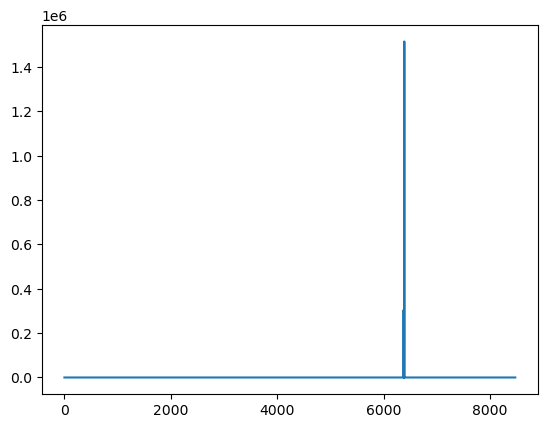

In [ ]:
plt.plot(model.losshistory)

In [ ]:
u00_1, v00_1, u00_2, v00_2 = model.predict1(test10_x,test10_t)
u11_1, v11_1, u11_2, v11_2 = model.predict1(testb_x1,testb_t1)
u22_1, v22_1, u22_2, v22_2 = model.predict1(testb_x2,testb_t2)
a1,b1,c1,d1, ux11_1, vx11_1, ux11_2, vx11_2 = model.predict2(testb_x1,testb_t1)
a1,b1,c1,d1, ux22_1, vx22_1, ux22_2, vx22_2 = model.predict2(testb_x2,testb_t2)

f1, f2, f3, f4,a1,b1,c1,d1 = model.predict2(testu_x,testu_t)     

C:\Users\npofsi\AppData\Local\Temp\ipykernel_3512\3777535164.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_3512\3777535164.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(Y, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_3512\3777535164.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, requires_grad=True).float().to(device)
C:\Users\npofsi\AppDat

In [ ]:
error_u0= ((np.linalg.norm(test10_r - u00_1, 2))**2+(np.linalg.norm(test10_c - v00_1, 2))**2+(np.linalg.norm(test20_r - u00_2, 2))**2+(np.linalg.norm(test20_c - v00_2, 2))**2)/20
error_ub= ((np.linalg.norm(u11_1 - u22_1, 2))**2+(np.linalg.norm(v11_1 - v22_1, 2))**2+(np.linalg.norm(u11_1 - u22_1, 2))**2+(np.linalg.norm(v11_1 - v22_1, 2))**2)/20
error_ubx= (
    (np.linalg.norm(ux11_1.cpu().detach().numpy() - ux22_1.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(vx11_1.cpu().detach().numpy() - vx22_1.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(ux11_2.cpu().detach().numpy() - ux22_2.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(vx11_2.cpu().detach().numpy() - vx22_2.cpu().detach().numpy(), 2))**2)/20

error_f= ((np.linalg.norm(f1, 2))**2+(np.linalg.norm(f2, 2))**2+(np.linalg.norm(f1, 2))**2+(np.linalg.norm(f2, 2))**2)/2000
print('Error_u0: %.5e, Error_ub: %.5e, Error_ubx: %.5e, Error_f: %.5e' % (error_u0.item(), error_ub.item(), error_ubx.item(), error_f.item()))




Error_u0: 5.27684e-02, Error_ub: 0.00000e+00, Error_ubx: 4.74056e-67, Error_f: 8.12052e-08
